# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data

In [3]:
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
print('Training Set')
print(len(X_train))
print(X_train.shape)
print(y_train.shape)

Training Set
60000
(60000, 28, 28)
(60000,)


In [6]:
print('Testing Set')
print(len(X_test))
print(X_test.shape)
print(y_test.shape)

Testing Set
10000
(10000, 28, 28)
(10000,)


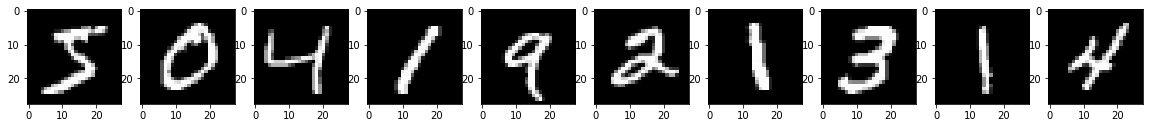

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X_train[i],cmap=plt.get_cmap('gray'))

In [8]:
X_train = 255 - X_train
X_test = 255 - X_test

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

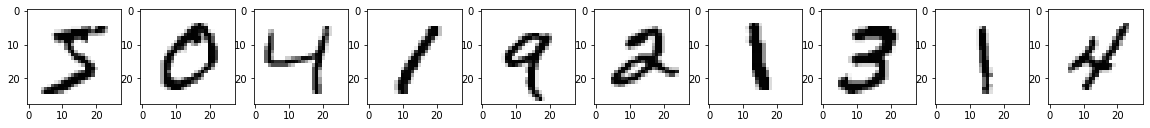

In [10]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X_train[i],cmap=plt.get_cmap('gray'))

# Preprocessing

In [11]:
from keras.utils.np_utils import to_categorical

In [12]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train.shape

(60000, 28, 28, 1)

In [13]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train.shape

(60000, 10)

In [14]:
X_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train,  y_test))

# Model Fitting

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

## Convolutional Neural Network

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
filepath = "lens-digi-3.h5"
ckpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(patience=2)

def cnn(image_size):
    classifier = Sequential()
    classifier.add(Conv2D(32, (5, 5), input_shape = (*image_size, 1), activation = 'relu', padding='same'))
    classifier.add(Conv2D(32, (5, 5), activation = 'relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))
    classifier.add(Flatten())
    classifier.add(Dense(units = 10, activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    classifier.summary()
    return classifier


model = cnn((28,28))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

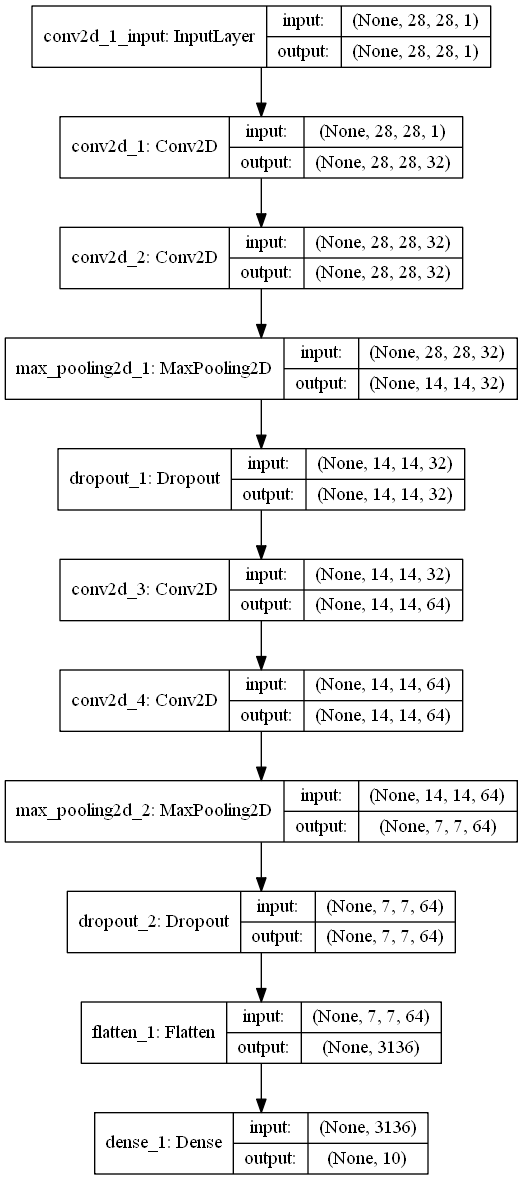

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN3.png', show_shapes=True, show_layer_names=True)

In [19]:
datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range = 0.1,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    validation_split=0.1
)  

datagen.fit(X_all)

training_set = datagen.flow(
    x=X_all, y=y_all,
    subset='training'
)

validation_set = datagen.flow(
    x=X_all, y=y_all,
    subset='validation'
)

In [20]:
history = model.fit_generator(training_set, validation_data=validation_set, epochs=1000, callbacks=[es, ckpt, rlp])

Epoch 1/1000
1969/1969 [==============================] - 820s 416ms/step - loss: 0.2698 - accuracy: 0.9132 - val_loss: 0.0412 - val_accuracy: 0.9776

Epoch 00001: val_loss improved from inf to 0.04116, saving model to lens-digi-3.h5
Epoch 2/1000
1969/1969 [==============================] - 872s 443ms/step - loss: 0.0896 - accuracy: 0.9727 - val_loss: 0.1852 - val_accuracy: 0.9790

Epoch 00002: val_loss did not improve from 0.04116
Epoch 3/1000
1969/1969 [==============================] - 852s 433ms/step - loss: 0.0701 - accuracy: 0.9783 - val_loss: 0.0018 - val_accuracy: 0.9830

Epoch 00003: val_loss improved from 0.04116 to 0.00184, saving model to lens-digi-3.h5
Epoch 4/1000
1969/1969 [==============================] - 843s 428ms/step - loss: 0.0637 - accuracy: 0.9811 - val_loss: 0.0668 - val_accuracy: 0.9851

Epoch 00004: val_loss did not improve from 0.00184
Epoch 5/1000
1969/1969 [==============================] - 832s 423ms/step - loss: 0.0559 - accuracy: 0.9831 - val_loss: 0.05

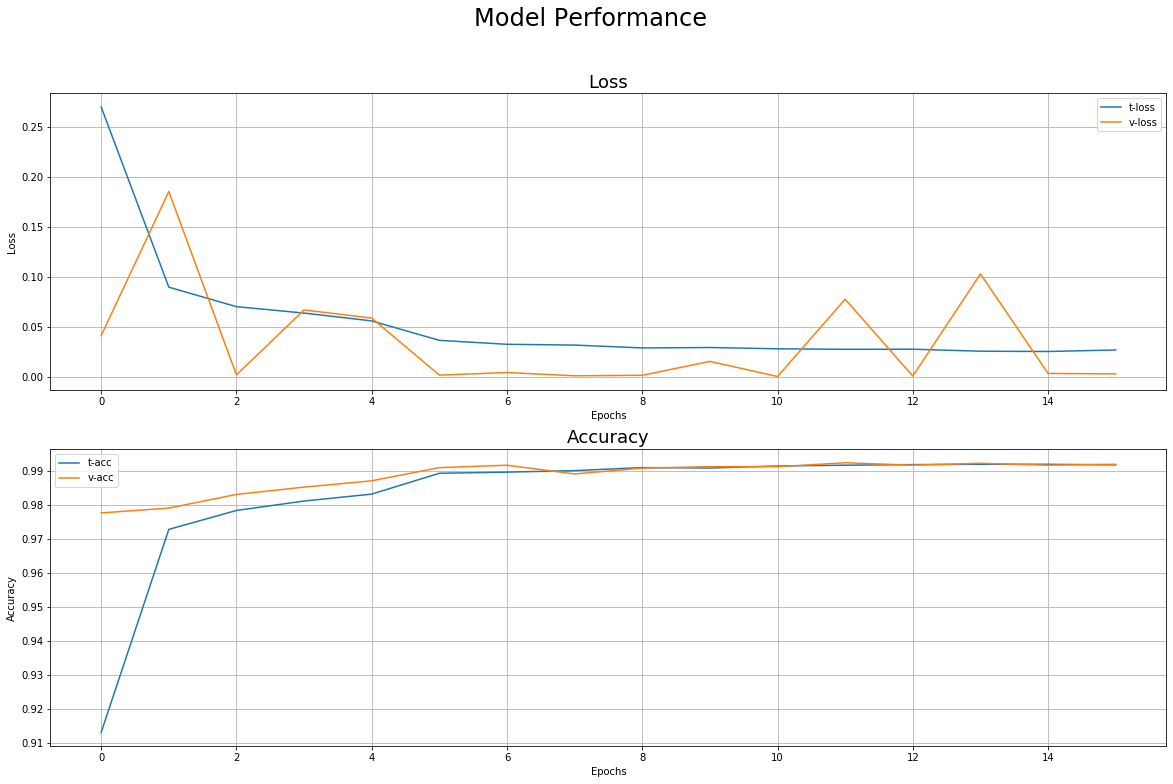

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['accuracy'], label='t-acc')
ax[1].plot(history.history['val_accuracy'], label='v-acc')
ax[1].set_title('Accuracy', fontsize=18)
ax[1].set_ylabel('Accuracy')


for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    
plt.savefig('Training3.png')    